In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style(style='darkgrid') 
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
%matplotlib inline

import scipy.stats as stats
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

# Scrubbing and initial exploration of data

In [2]:
df = pd.read_csv("kc_house_data.csv")
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [3]:
# Removing columns that aren't required for modeling
cols_to_drop = ['id']
df.drop(columns=cols_to_drop, inplace=True)

In [4]:
# checking missing values and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 20 columns):
date             21613 non-null object
price            21613 non-null float64
bedrooms         21613 non-null int64
bathrooms        21613 non-null float64
sqft_living      21613 non-null int64
sqft_lot         21613 non-null int64
floors           21613 non-null float64
waterfront       21613 non-null int64
view             21613 non-null int64
condition        21613 non-null int64
grade            21613 non-null int64
sqft_above       21613 non-null int64
sqft_basement    21613 non-null int64
yr_built         21613 non-null int64
yr_renovated     21613 non-null int64
zipcode          21613 non-null int64
lat              21613 non-null float64
long             21613 non-null float64
sqft_living15    21613 non-null int64
sqft_lot15       21613 non-null int64
dtypes: float64(5), int64(14), object(1)
memory usage: 3.3+ MB


In [5]:
df['date'] = pd.to_datetime(df['date'])
df['zipcode'] = df['zipcode'].astype('category')
for col in ['yr_built', 'yr_renovated']:
    df[col] = pd.to_datetime(df[col]).dt.to_period('Y')


In [6]:
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,47.560053,-122.213896,1986.552492,12768.455652
std,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,0.138564,0.140828,685.391304,27304.179631
min,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,47.155900,-122.519000,399.000000,651.000000
25%,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,47.678000,-122.125000,2360.000000,10083.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,47.777600,-121.315000,6210.000000,871200.000000


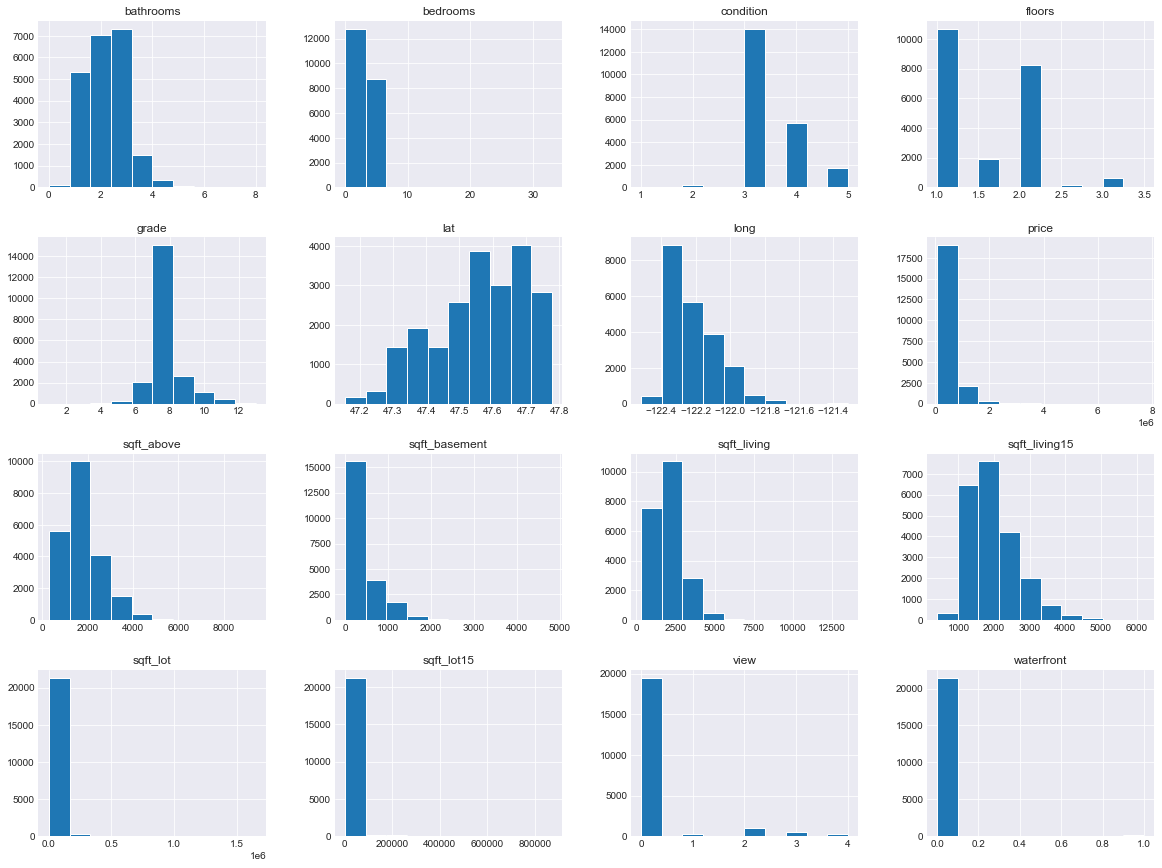

In [7]:
df.hist(figsize=(20,15))
plt.show()

# Outliers and Normality Checks 

In order to keep track of which variables will be transformed, let's create a "to_normalize" list and store features in it along the way

In [8]:
to_normalize = []
to_drop = []

## Dependent Variable

In [9]:
def dep_var_dist(dependent_variable ='price', df=df, logtransform=False):
    log_trans = ''
    if logtransform:
        df = df.apply(np.log)
        log_trans = 'Log Transformed '

    # dependent variable PRICE

    f, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 5), sharex=True)
    f.suptitle('Distribution of '+ log_trans + dependent_variable.title() + ' Data', x=0.52, y=1, fontsize=16)

    plt.subplots_adjust(hspace=0.3)

    data = df[dependent_variable]
    sns.boxplot(x=data, ax=ax1)
    ax1.set_title('Boxplot', fontsize=12)
    ax1.set_xlabel('')


    sns.distplot(data, kde=True, hist=True,
             hist_kws={"linewidth": 1,"edgecolor" :'red', "alpha": 0.4,
                         "color":  "w", "label": "Histogram"},
             kde_kws = {'linewidth': 1, 'color': "blue",  "alpha": 0.7,
                                    'label':'Kernel Density Estimation Plot'} ,ax=ax2)


    ax2.set_title('Distplot', fontsize=12)
    ax2.set_xlabel(dependent_variable)
    plt.show()



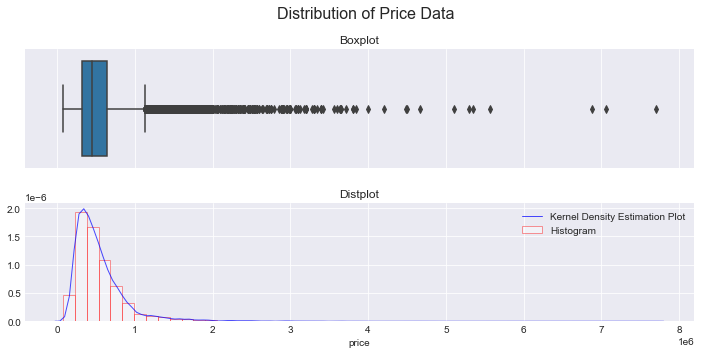

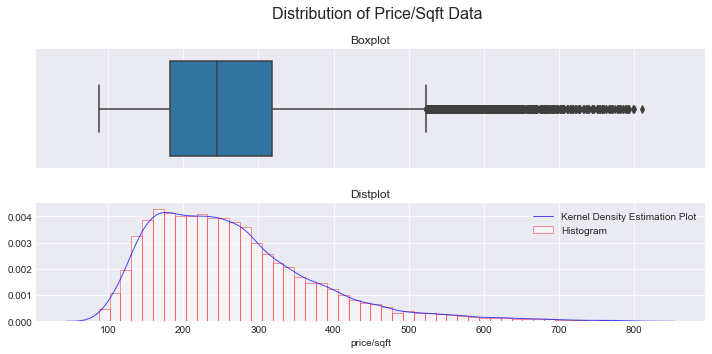

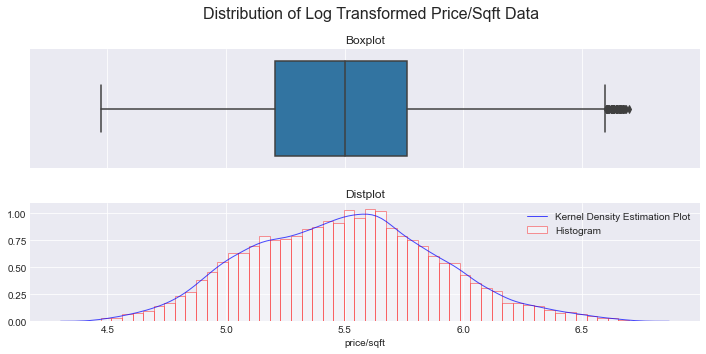

In [10]:
#plots dependent variable as is
dep_var_dist()

#plots price/sqft as the dependent variable
df['price/sqft'] = df['price']/df['sqft_living']
dep_var_dist(dependent_variable='price/sqft')

#plots logtransformed price/sqft as dependent variable 
dep_var_dist(dependent_variable='price/sqft', df=df[['price/sqft']], logtransform=True)

The variable 'price' is somewhat normal, even though it is strongly skewed by outliers. The distribution becomes less skewed if we look at price/sqft. 

the log transformation of price/sqft improves the distribution further, which is why 

In [11]:
to_normalize.append('price/sqft')

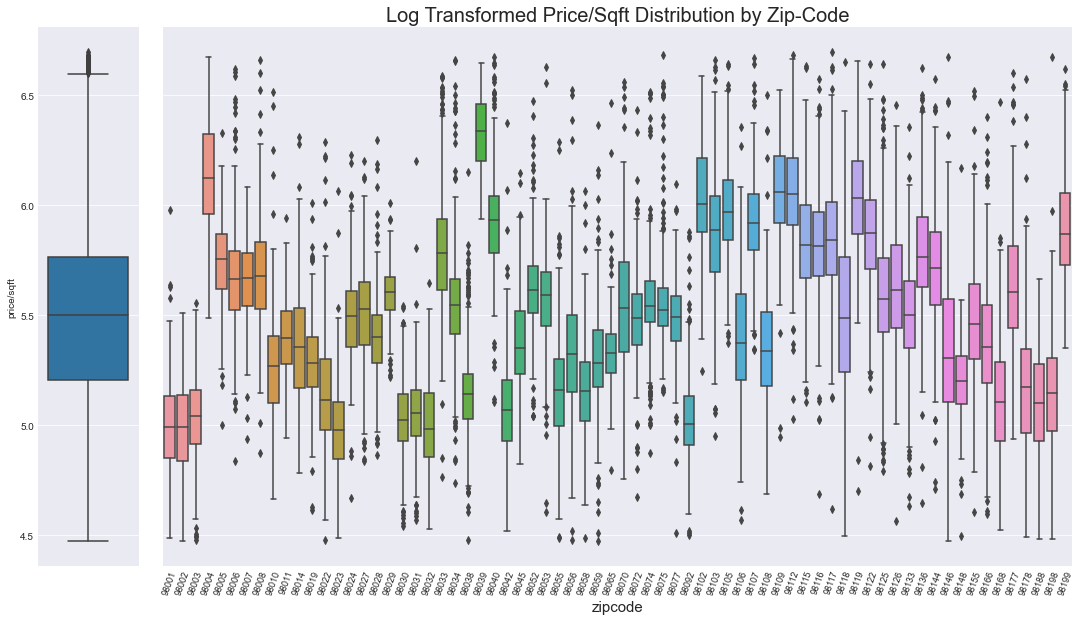

In [12]:
# boxplots of price/sqft for each zip-code
f, axes = plt.subplots(1, 2, figsize=(15,8), sharey = True, gridspec_kw={"width_ratios": (.1, .9)})
f.tight_layout()
data = df[['price/sqft', 'sqft_living', 'zipcode']]
data['price/sqft'] = data['price/sqft'].apply(np.log)


a = sns.boxplot(x=data['price/sqft'], orient='v', ax=axes[0])

b = sns.boxplot(x="zipcode", y=('price/sqft'), data=data, ax=axes[1])
b.set_title("Log Transformed Price/Sqft Distribution by Zip-Code",fontsize=20)
b.set_xlabel("zipcode",fontsize=15)
b.set_ylabel("",)
b.tick_params(labelsize=9)

plt.xticks(rotation=70)

plt.show()

## Independent Variables

In [13]:
def check_distribution(cols, df=df):
    
    
    for col in cols:
        fig, axes = plt.subplots(2, 
                                 sharex='col',  gridspec_kw={"height_ratios": (.15, .85)}, 
                                 figsize = (15,5))
        fig.suptitle(col.title(), fontsize=20).set_position([.5, 1.05])
        
        # top  plot
        sns.boxplot(x=df[col], ax = axes[0],color = 'red')
        axes[0].set_title('Boxplot', fontsize=12)
        axes[0].set_xlabel('')
        
        # middle plot
        sns.distplot(df[col], hist=True, 
                     hist_kws={"linewidth": 1, "edgecolor" :'red', "alpha": 0.4,
                               "color":  "w", "label": "Histogram"},
                     kde=True, kde_kws = {'linewidth': 1, 'color': "blue", 
                                          "alpha": 0.7, 'label':'Kernel Density Estimation Plot'},
                     fit= stats.norm, 
                     fit_kws = {'color' : 'green', 'label' : 'parametric fit',
                                "alpha": 0.7, 'linewidth':3},
                 ax=axes[1])
        axes[1].set_title('Density Estimations', fontsize=12)
        axes[1].set_ylabel('frequency/probability')
        axes[1].set_xlabel(col)
        axes[1].legend()
        plt.show()
        ################
#         fig2, axes2 = plt.subplots(1, 2, 
#                                    sharey='row', 
#                                    gridspec_kw={"width_ratios": (.1, .9)}, 
#                                    figsize = (12.3,5) )
#         fig2.tight_layout()
#         # bottom left plot
#         sns.boxplot(y="price/sqft", data=df, ax=axes2[0])
#         #axes2[0].set_xticks([])
#         axes2[0].set_xlabel('')
#         axes2[0].set_title('Price/sqft Boxplot', fontsize=12)




#         # bottom right plot
#         axes2[1].scatter(df[col], df["price/sqft"],alpha=.051)
#         axes2[1].set_xlabel(col)
#         axes2[1].set_ylabel('')

#         #plt.legend();
        plt.show()
    

### Bedrooms

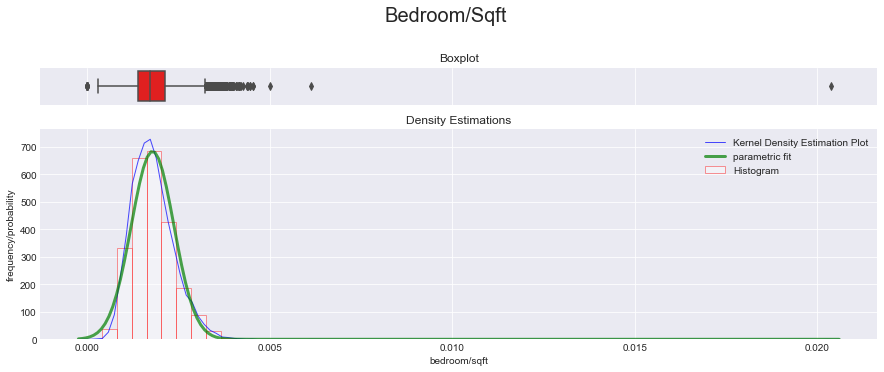

In [20]:
df['bedroom/sqft'] = df['bedrooms']/ df['sqft_living']
check_distribution(cols=['bedroom/sqft'], df=df)

In order to evaluate outliers, let's assume that a reasonable top threshold for bedrooms per square feet is 0.005. This would translate into a 1000 sqft property with 5+ bedrooms.

n of outliers removed: 2


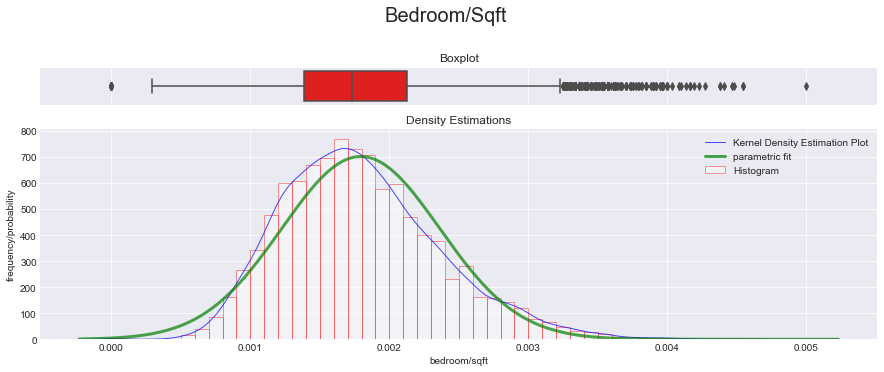

In [21]:
df['bedrooms/sqft'] = df['bedrooms']/df['sqft_living']
outlier_filt = df['bedrooms/sqft'] > 5/1000
outlier_index = df.loc[outlier_filt].index
print('n of outliers removed:', len(outlier_index))
df.drop(index=outlier_index, inplace=True)

check_distribution(cols=['bedroom/sqft'], df=df)

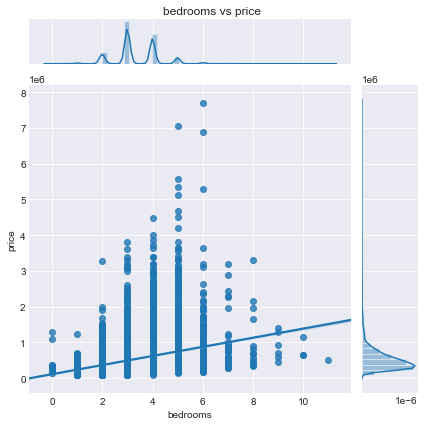

In [30]:
p = sns.jointplot(x='bedrooms', y='price', data=df, kind='reg')
p.fig.suptitle("bedrooms vs price")
p.fig.tight_layout()
p.fig.subplots_adjust(top=0.95)

- Distribution looks normal enough
- somewhat positive linear correlation with price: linear correlation could be related to multicolinearity of bedrooms with sqft_living

Let's plot bedrooms/sqft against price to see if there are obvious signs of multicollinearity 

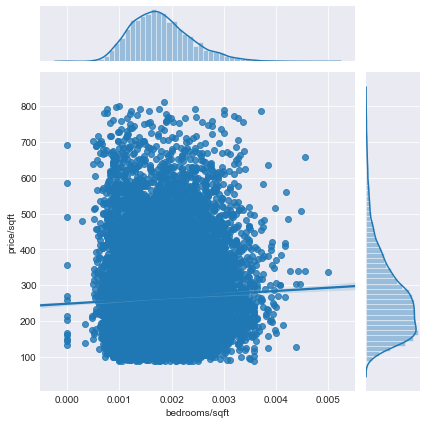

In [31]:

sns.jointplot(x='bedrooms/sqft', y='price/sqft', data=df, kind='reg')
plt.show()

- no obvious correlation appears to exist  

## Bathrooms

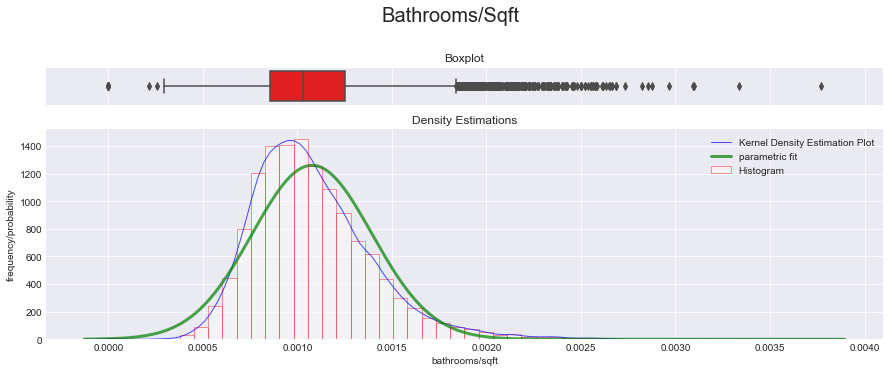

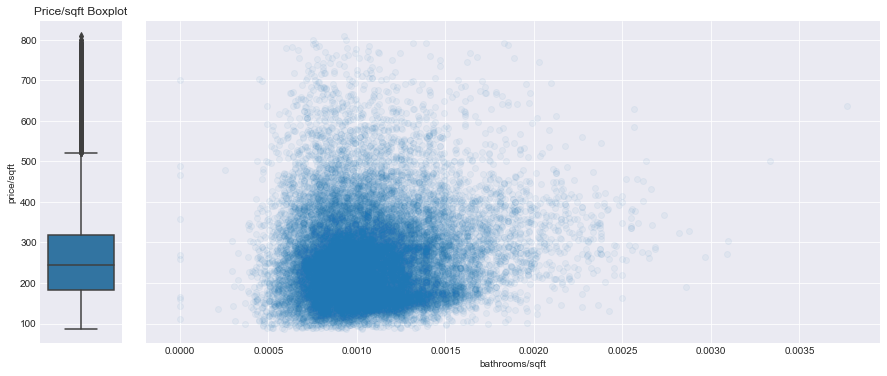

In [15]:
data = df[['bathrooms', 'sqft_living', 'price/sqft']]
data['bathrooms/sqft'] = data['bathrooms']/ data['sqft_living']
check_distribution(cols=['bathrooms/sqft'], df=data)

In order to spot outliers, let's assume that a reasonable top threshold for bathroom per square feet is 0.003. This would translate into a 1000 sqft property with 3 bathrooms.

In [16]:
df['bathrooms/sqft'] = df['bathrooms']/df['sqft_living']
outlier_filt = df['bathrooms/sqft'] > 3/1000
outlier_index = df.loc[outlier_filt].index
print('n of outliers', len(outlier_index))
df.drop(index=outlier_index, inplace=True)

n of outliers 4


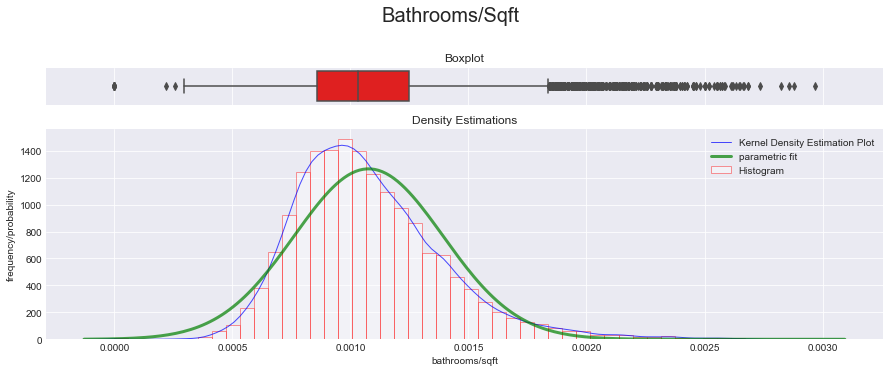

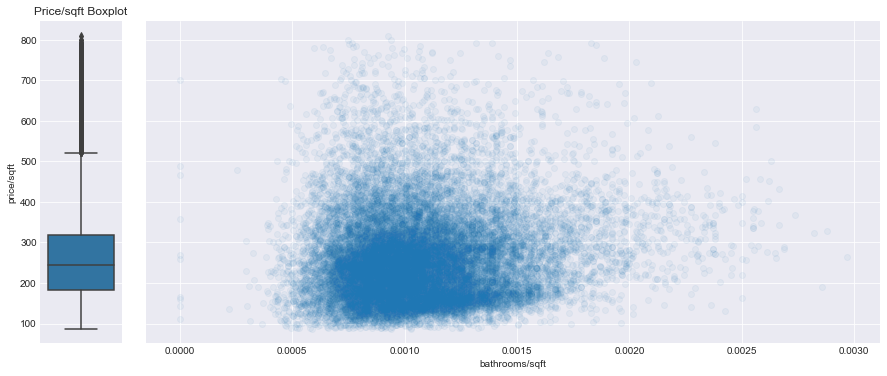

In [17]:
check_distribution(cols=['bathrooms/sqft'], df=df)

## Sqft_living

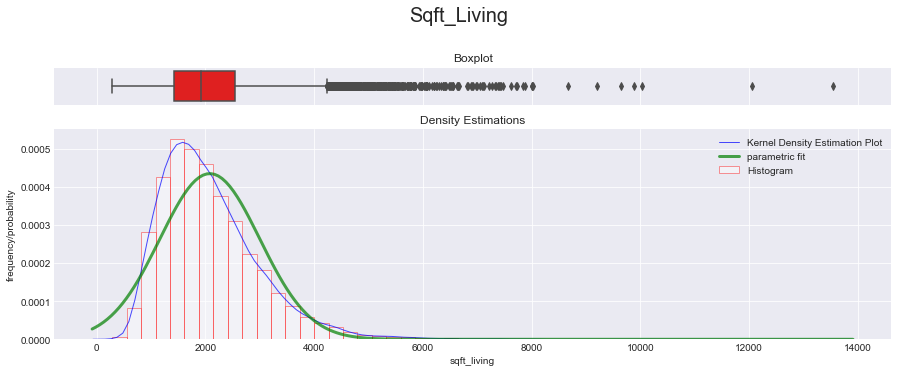

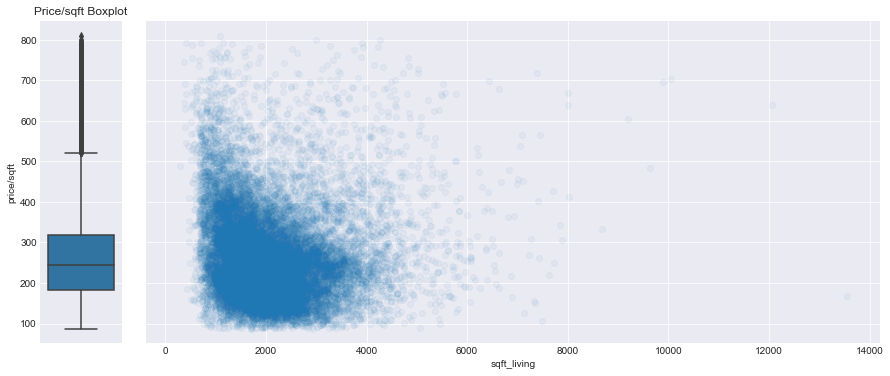

In [18]:
data = df[['sqft_living', 'price/sqft']]
check_distribution(cols=['sqft_living'], df=data)

## Sqft_lot

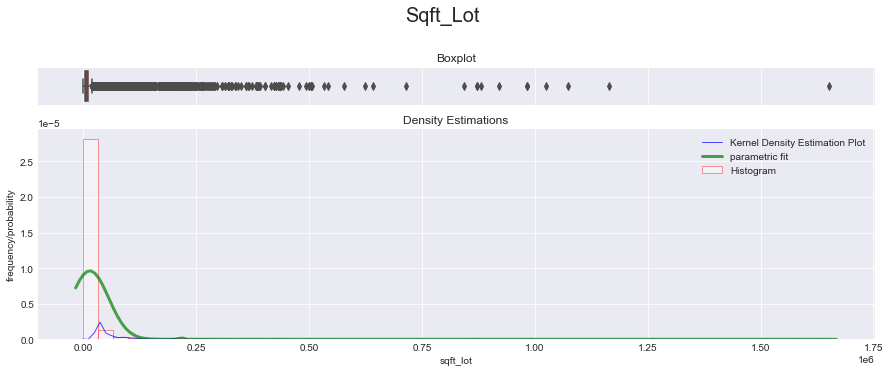

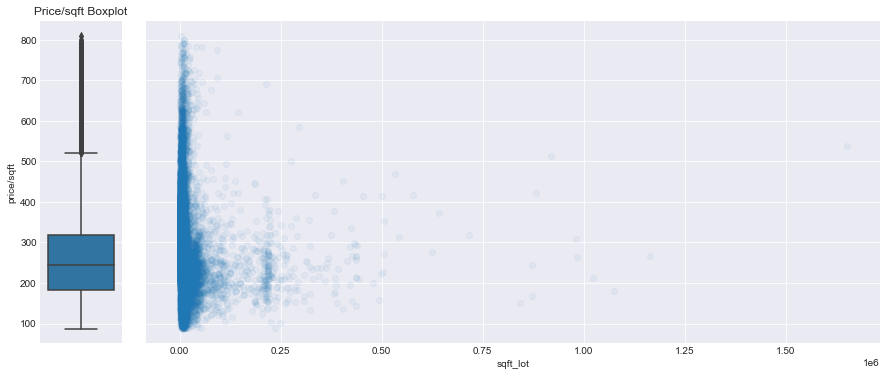

In [19]:
data = df[['sqft_lot', 'price', 'price/sqft']]

check_distribution(cols=['sqft_lot'], df=data)

## Floors

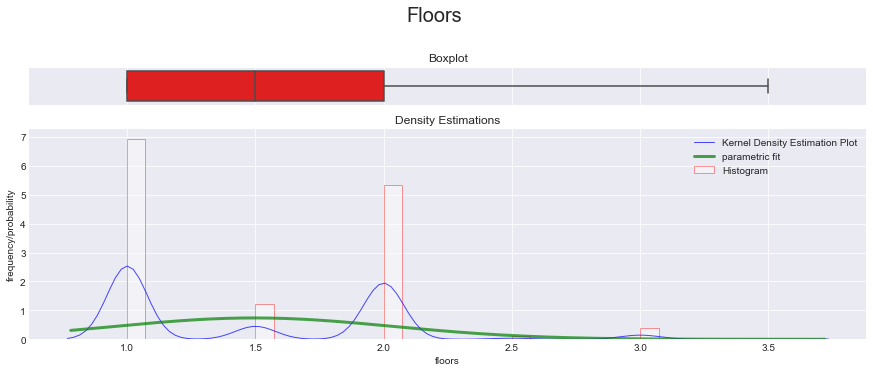

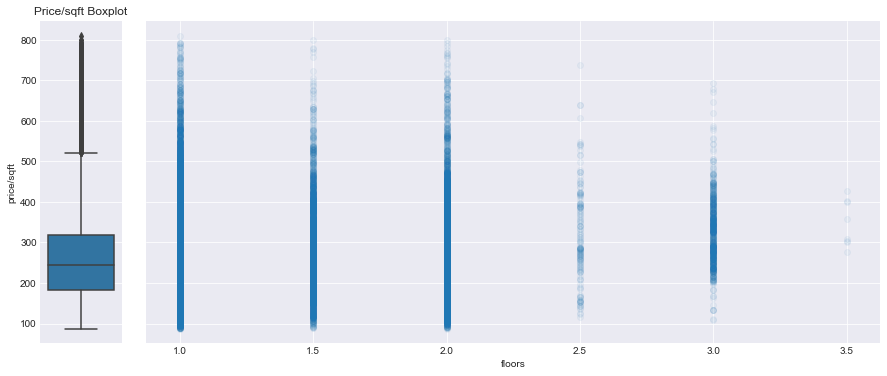

In [21]:
data = df[['floors', 'price', 'price/sqft']]

check_distribution(cols=['floors'], df=data)

# Multicollinearity

In [ ]:
check_distribution()

In [159]:
for col in df.columns:
    zeros = (df[col] == 0).sum()
    if zeros:
        print(col, zeros)

bedrooms 13
bathrooms 10
waterfront 21450
view 19489
sqft_basement 13126
yr_renovated 20699


In [166]:
df[df['bedrooms'] == 0]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price/sqft
875,6306400140,2014-06-12,1095000.0,0,0.00,3064,4764,3.5,0,2,...,3064,0,1990,0,98102,47.6362,-122.322,2360,4000,357.375979
3119,3918400017,2015-02-05,380000.0,0,0.00,1470,979,3.0,0,2,...,1470,0,2006,0,98133,47.7145,-122.356,1470,1399,258.503401
3467,1453602309,2014-08-05,288000.0,0,1.50,1430,1650,3.0,0,0,...,1430,0,1999,0,98125,47.7222,-122.290,1430,1650,201.398601
4868,6896300380,2014-10-02,228000.0,0,1.00,390,5900,1.0,0,0,...,390,0,1953,0,98118,47.5260,-122.261,2170,6000,584.615385
6994,2954400190,2014-06-24,1295650.0,0,0.00,4810,28008,2.0,0,0,...,4810,0,1990,0,98053,47.6642,-122.069,4740,35061,269.365904
8477,2569500210,2014-11-17,339950.0,0,2.50,2290,8319,2.0,0,0,...,2290,0,1985,0,98042,47.3473,-122.151,2500,8751,148.449782
8484,2310060040,2014-09-25,240000.0,0,2.50,1810,5669,2.0,0,0,...,1810,0,2003,0,98038,47.3493,-122.053,1810,5685,132.596685
9773,3374500520,2015-04-29,355000.0,0,0.00,2460,8049,2.0,0,0,...,2460,0,1990,0,98031,47.4095,-122.168,2520,8050,144.308943
9854,7849202190,2014-12-23,235000.0,0,0.00,1470,4800,2.0,0,0,...,1470,0,1996,0,98065,47.5265,-121.828,1060,7200,159.863946
12653,7849202299,2015-02-18,320000.0,0,2.50,1490,7111,2.0,0,0,...,1490,0,1999,0,98065,47.5261,-121.826,1500,4675,214.765101


 First look into our dependent and independent variables

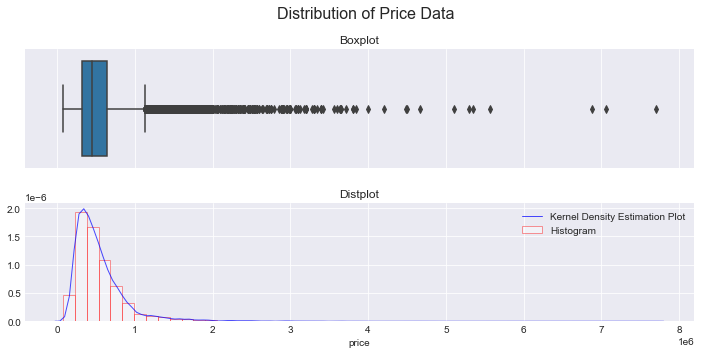

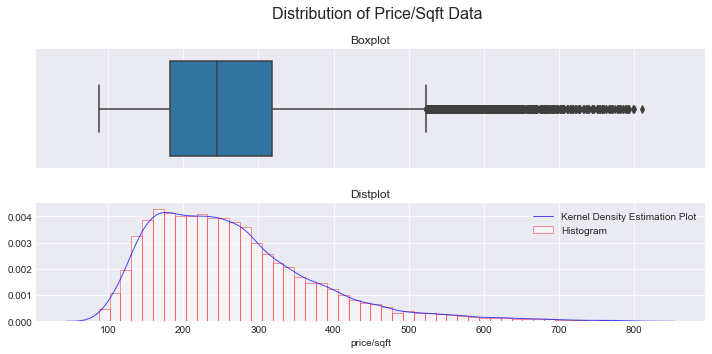

In [120]:
# dependent variable PRICE

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 5), sharex=True)
f.suptitle('Distribution of Price Data', x=0.52, y=1, fontsize=16)

plt.subplots_adjust(hspace=0.3)

data = df['price']
sns.boxplot(x=data, ax=ax1)
ax1.set_title('Boxplot', fontsize=12)
ax1.set_xlabel('')


sns.distplot(data, kde=True, hist=True,
             hist_kws={"linewidth": 1,"edgecolor" :'red', "alpha": 0.4,
                         "color":  "w", "label": "Histogram"},
             kde_kws = {'linewidth': 1, 'color': "blue",  "alpha": 0.7,
                                    'label':'Kernel Density Estimation Plot'} ,ax=ax2)


ax2.set_title('Distplot', fontsize=12)
plt.show()


# dependent variable PRICE/SQFT

data = (df['price'] / df['sqft_living']).values
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 5), sharex=True)
f.suptitle('Distribution of Price/Sqft Data', x=0.52, y=1, fontsize=16)

plt.subplots_adjust(hspace=0.3)


sns.boxplot(x=data, ax=ax1)
ax1.set_title('Boxplot', fontsize=12)
ax1.set_xlabel('')


sns.distplot(data, kde=True, hist=True,
             hist_kws={"linewidth": 1,"edgecolor" :'red', "alpha": 0.4,
                         "color":  "w", "label": "Histogram"},
             kde_kws = {'linewidth': 1, 'color': "blue",  "alpha": 0.7,
                                    'label':'Kernel Density Estimation Plot'} ,ax=ax2)

ax2.set_xlabel('price/sqft')
ax2.set_title('Distplot', fontsize=12)
plt.show()





Both distribution are positively skewed, but PRICE is more affected by large outliers than PRICE/SQFT


A second quick check is to visualize the price distribution for each zipcode. This will help see how much outliers can be explained by the property's location

C:\Users\felip\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


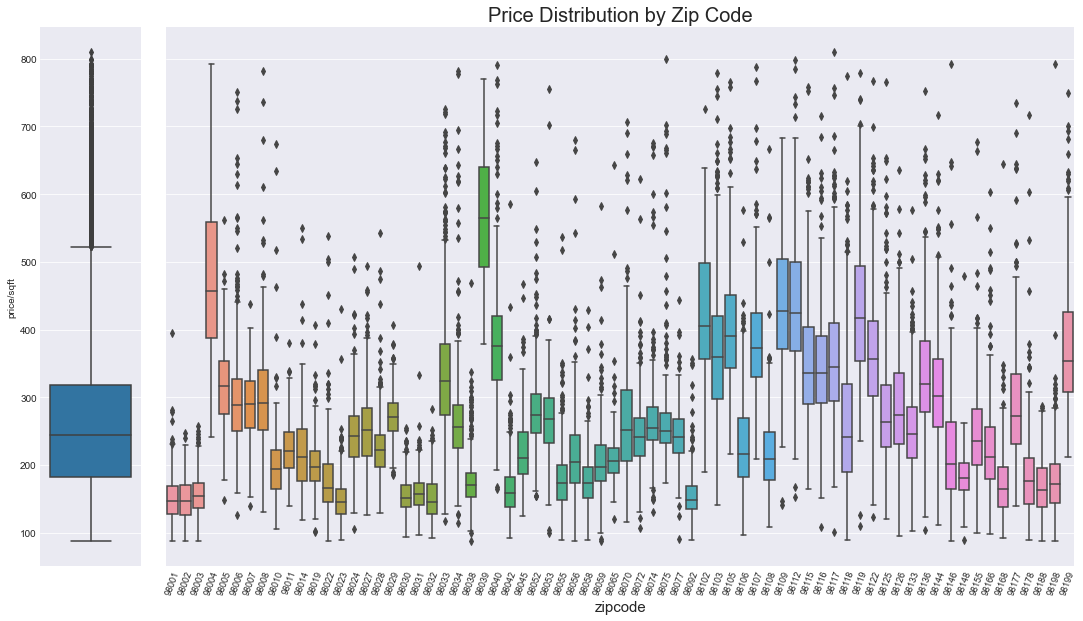

In [131]:
f, axes = plt.subplots(1, 2, figsize=(15,8), sharey = True, gridspec_kw={"width_ratios": (.1, .9)})
f.tight_layout()
data = df[['price', 'sqft_living', 'zipcode']]
data['price/sqft'] = df['price']/df['sqft_living']


a = sns.boxplot(x=data['price/sqft'], orient='v', ax=axes[0])

b = sns.boxplot(x="zipcode", y=('price/sqft'), data=data, ax=axes[1])
b.set_title("Price Distribution by Zip Code",fontsize=20)
b.set_xlabel("zipcode",fontsize=15)
b.set_ylabel("",)
b.tick_params(labelsize=9)

plt.xticks(rotation=70)

plt.show()

Even though the price\sqft distribution of a few zip-codes explain some of the outliers in the general distribution, all zip-codes contain outliers themselves. 

Let's now investigate the distributions of the independent variables

In [149]:
def check_distribution(df, cols):
    
    
    for col in cols:
        fig, axes = plt.subplots(2, 
                                 sharex='col',  gridspec_kw={"height_ratios": (.15, .85)}, 
                                 figsize = (15,5))
        fig.suptitle(col.title(), fontsize=20).set_position([.5, 1.05])
        
        # top  plot
        sns.boxplot(x=df[col], ax = axes[0],color = 'red')
        axes[0].set_title('Boxplot', fontsize=12)
        axes[0].set_xlabel('')
        
        # middle plot
        sns.distplot(df[col], hist=True, 
                     hist_kws={"linewidth": 1, "edgecolor" :'red', "alpha": 0.4,
                               "color":  "w", "label": "Histogram"},
                     kde=True, kde_kws = {'linewidth': 1, 'color': "blue", 
                                          "alpha": 0.7, 'label':'Kernel Density Estimation Plot'},
                     fit= stats.norm, 
                     fit_kws = {'color' : 'green', 'label' : 'parametric fit',
                                "alpha": 0.7, 'linewidth':3},
                 ax=axes[1])
        axes[1].set_title('Density Estimations', fontsize=12)
        axes[1].set_ylabel('frequency/probability')
        axes[1].set_xlabel(col)
        axes[1].legend()
        plt.show()
        ################
        fig2, axes2 = plt.subplots(1, 2, 
                                   sharey='row', 
                                   gridspec_kw={"width_ratios": (.1, .9)}, 
                                   figsize = (12.3,5) )
        fig2.tight_layout()
        # bottom left plot
        sns.boxplot(y="price/sqft", data=df, ax=axes2[0])
        #axes2[0].set_xticks([])
        axes2[0].set_xlabel('')
        axes2[0].set_title('Price/sqft Boxplot', fontsize=12)




        # bottom right plot
        axes2[1].scatter(df[col], df["price/sqft"],alpha=.051)
        axes2[1].set_xlabel(col)
        axes2[1].set_ylabel('')

        #plt.legend();
        plt.show()
    

OverflowError: cannot convert float infinity to integer

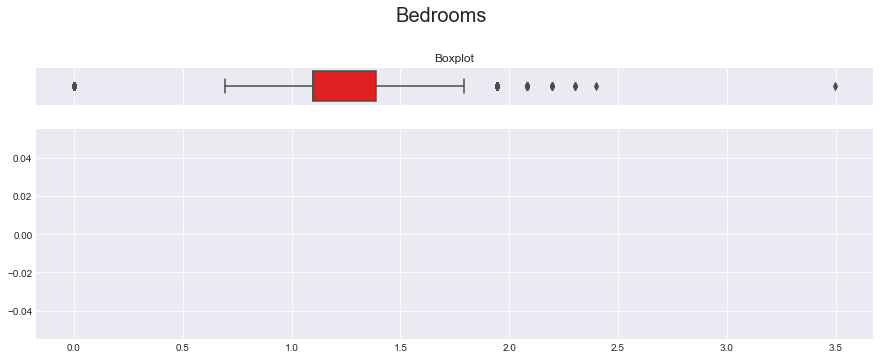

In [153]:
check_distribution(df[["price/sqft", 'bedrooms']].apply(np.log), ['bedrooms'])

In [ ]:
def ks_plot(data, distribution=stats.norm):
    
    std = data.std()
    loc = data.mean()
    min_ = data.min()
    max_ = data.max()
    x = np.linspace(loc-4*std, loc+4*std, len(data))
    
    y = distribution.cdf(x, loc=loc, scale=std)

    plt.figure(figsize=(10,4))
    plt.plot(np.sort(data), np.linspace(0, 1, len(data)))
    plt.plot(x, y)
    plt.legend(['ECDF', 'CDF'])
    plt.title('Comparing CDFs for K-S test, Sample size=' + str(len(data)))
    return

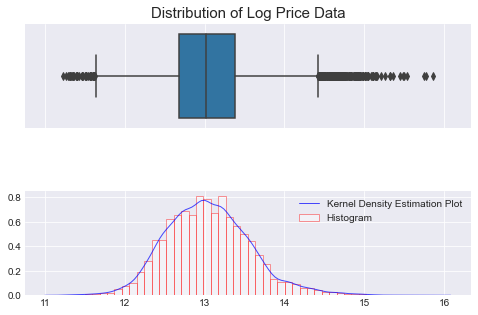

d_stat: 1.0
p_value: 0.0


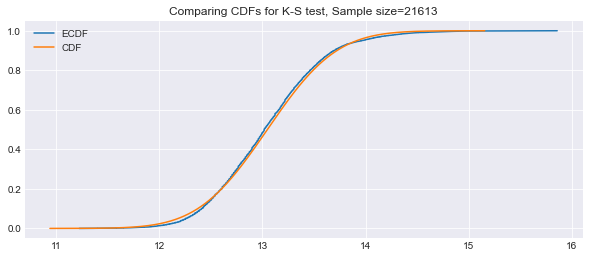

In [79]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 5), sharex=True)
#plt.title('Distribution of Price Data')
plt.subplots_adjust(hspace=0.6)

data = np.sort(df['price'].apply(np.log))

sns.boxplot(x=data, ax=ax1)
sns.distplot(data, kde=True, hist=True,
            hist_kws={"linewidth": 1,"edgecolor" :'red', "alpha": 0.4,
                         "color":  "w", "label": "Histogram"},
            kde_kws = {'linewidth': 1, 'color': "blue",  "alpha": 0.7,
                                    'label':'Kernel Density Estimation Plot'})
ax1.set_title('Distribution of Log Price Data', fontsize=15)

plt.show()


ks_plot(data)


# K-S test to test normality
d_stat, p_value =  stats.kstest(data, 'norm')
print('d_stat:', d_stat)
print('p_value:', p_value)



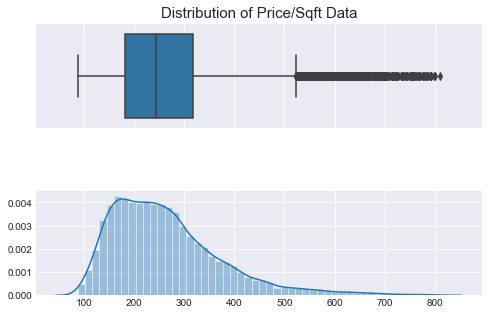

d_stat: 1.0
p_value: 0.0


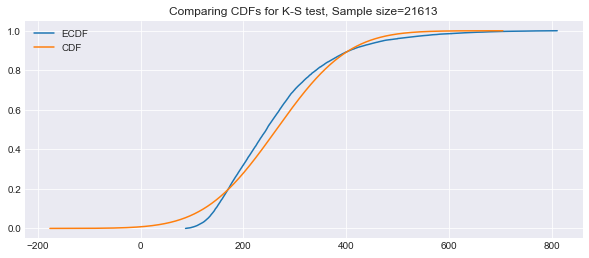

In [70]:
df['price/sqft'] = df['price'] / df['sqft_living']

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 5), sharex=True)
#plt.title('Distribution of Price Data')
plt.subplots_adjust(hspace=0.6)


data = df["price/sqft"].values

sns.boxplot(x=data, ax=ax1)
sns.distplot(data, kde=True, hist=True)
ax1.set_title('Distribution of Price/Sqft Data', fontsize=15)

plt.show()


ks_plot(data)

# K-S test to test normality
d_stat, p_value =  stats.kstest(data, 'norm')
print('d_stat:', d_stat)
print('p_value:', p_value)


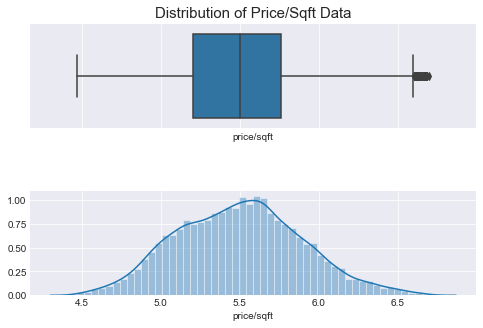

d_stat: 0.9999961371316105
p_value: 0.0


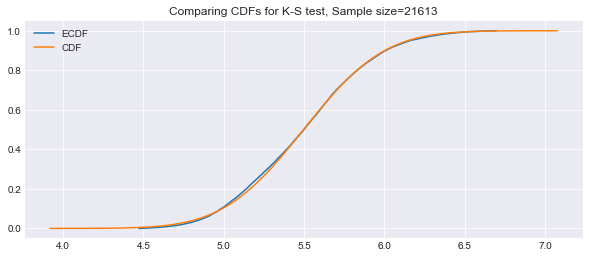

In [71]:

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 5), sharex=True)
#plt.title('Distribution of Price Data')
plt.subplots_adjust(hspace=0.6)


data = df["price/sqft"].apply(np.log)

sns.boxplot(x=data, ax=ax1)
sns.distplot(data, kde=True, hist=True)
ax1.set_title('Distribution of Price/Sqft Data', fontsize=15)

plt.show()


ks_plot(data)

# K-S test to test normality
d_stat, p_value =  stats.kstest(data, 'norm')
print('d_stat:', d_stat)
print('p_value:', p_value)


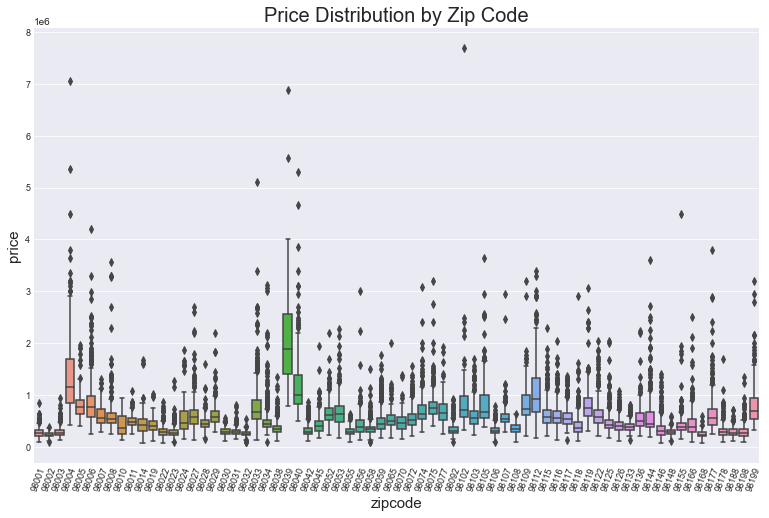

In [20]:
plt.figure(figsize=(13,8))

b = sns.boxplot(x="zipcode", y=('price'), data=df)
plt.title("Price Distribution by Zip Code",fontsize=20)
b.set_xlabel("zipcode",fontsize=15)
b.set_ylabel("price",fontsize=15)
b.tick_params(labelsize=9)

plt.xticks(rotation=70)

plt.show()

C:\Users\felip\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


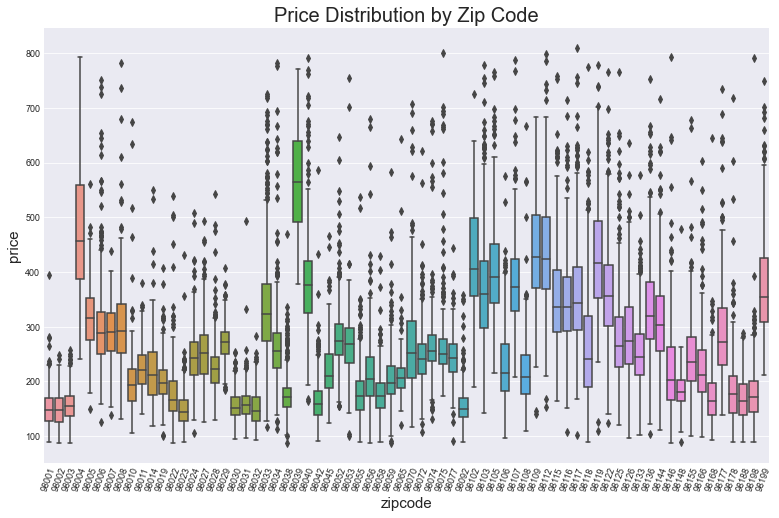

In [21]:
plt.figure(figsize=(13,8))
data = df[['price', 'sqft_living', 'zipcode']]
data['price/sqft'] = df['price']/df['sqft_living']
b = sns.boxplot(x="zipcode", y=('price/sqft'), data=data)
plt.title("Price Distribution by Zip Code",fontsize=20)
b.set_xlabel("zipcode",fontsize=15)
b.set_ylabel("price",fontsize=15)
b.tick_params(labelsize=9)

plt.xticks(rotation=70)

plt.show()

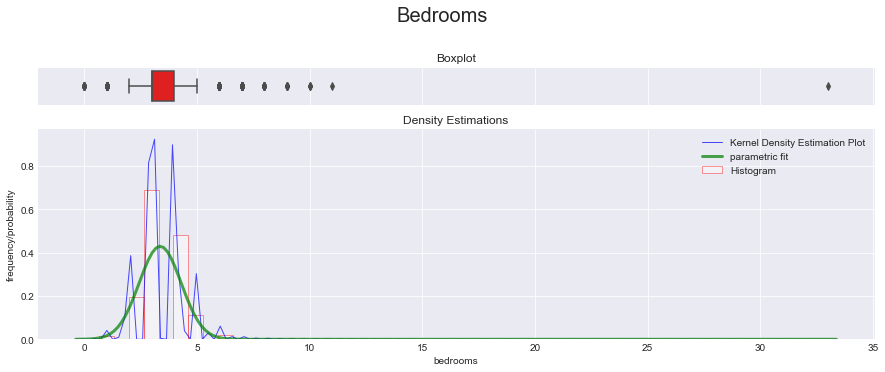

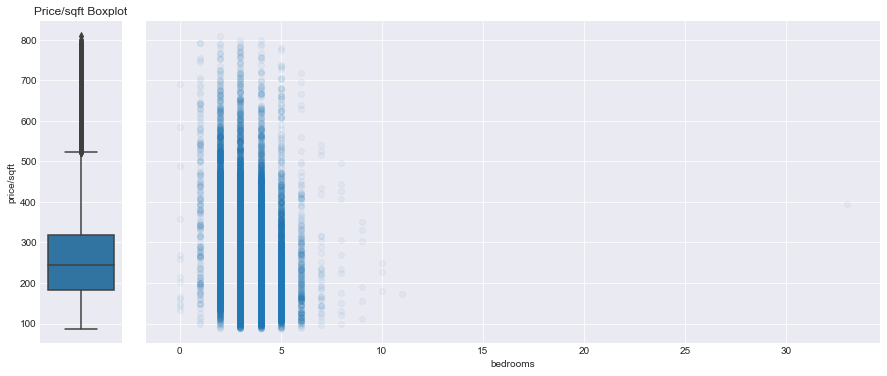

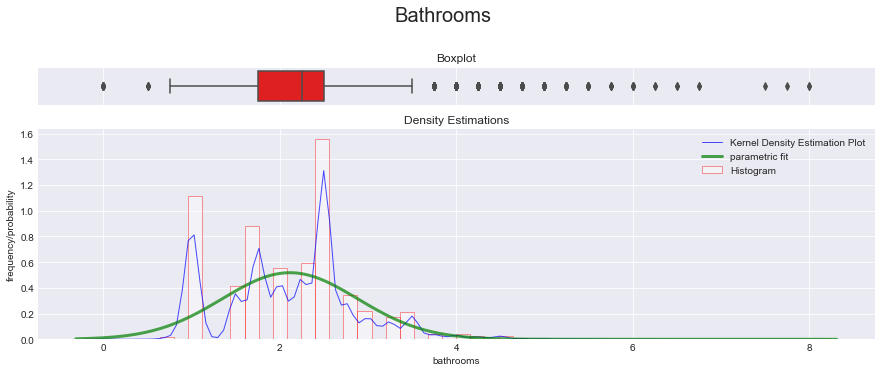

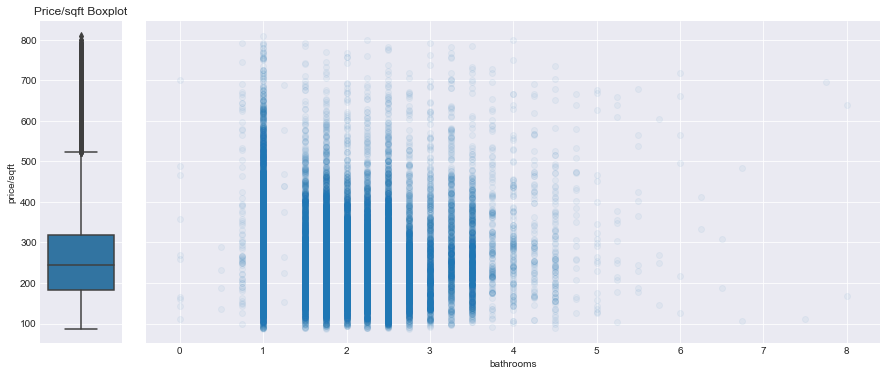

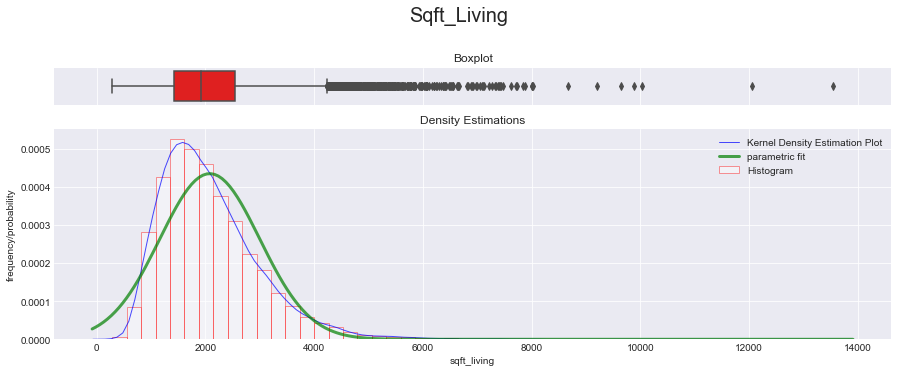

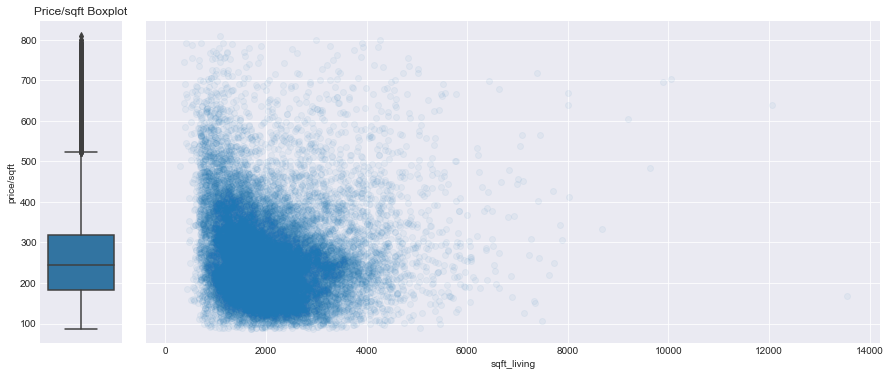

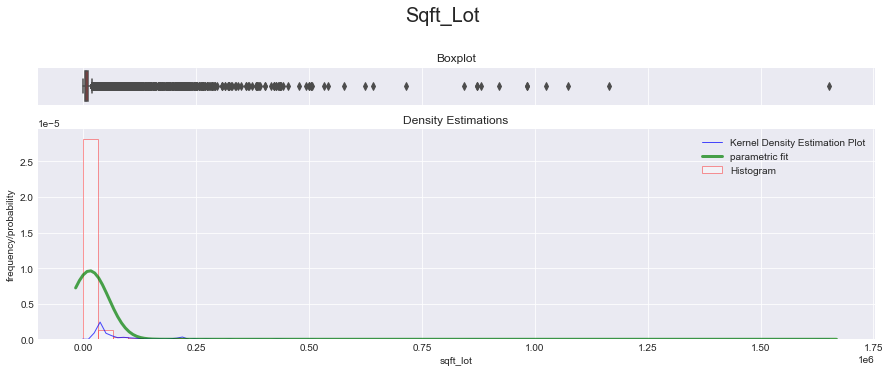

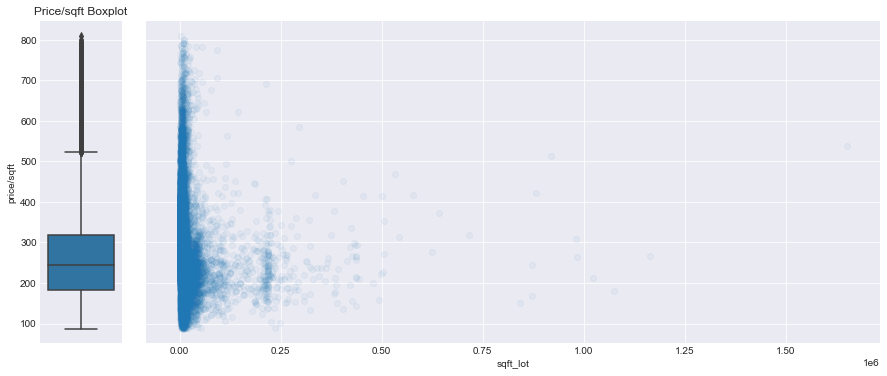

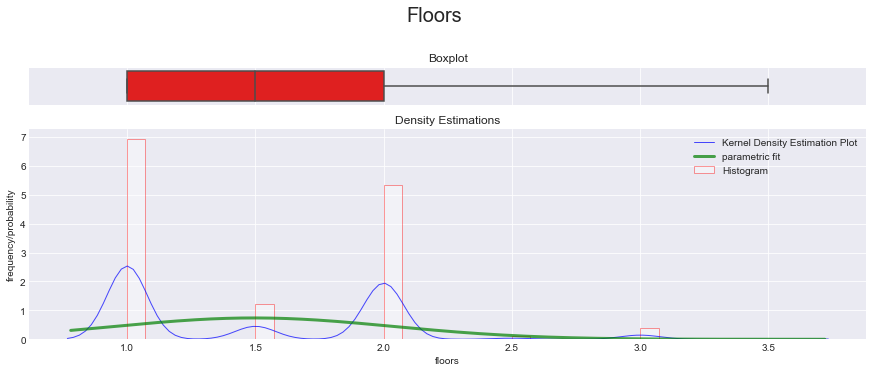

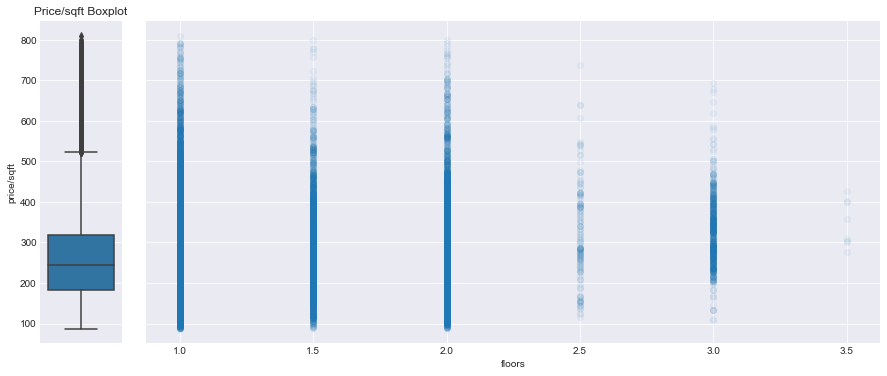

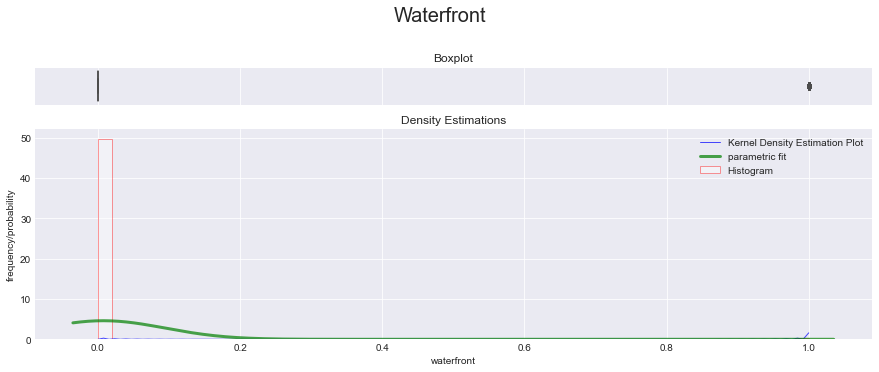

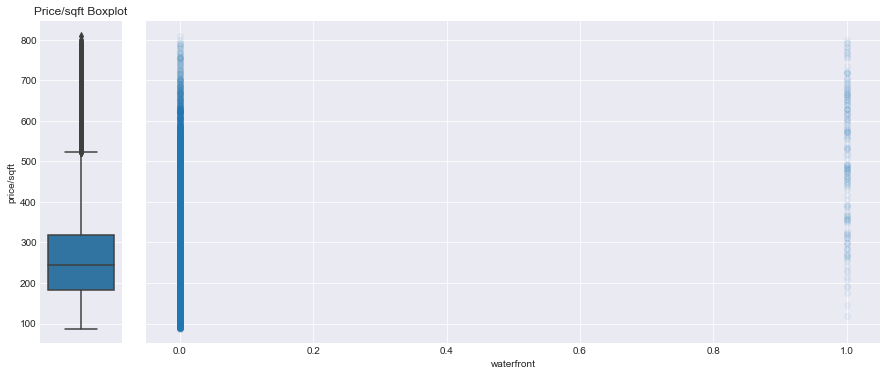

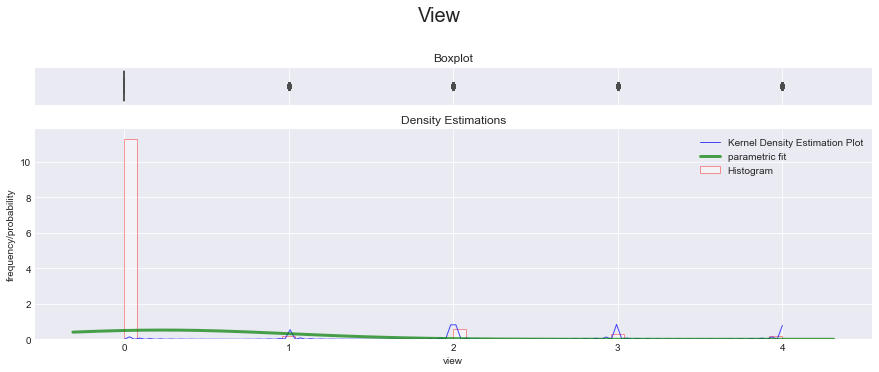

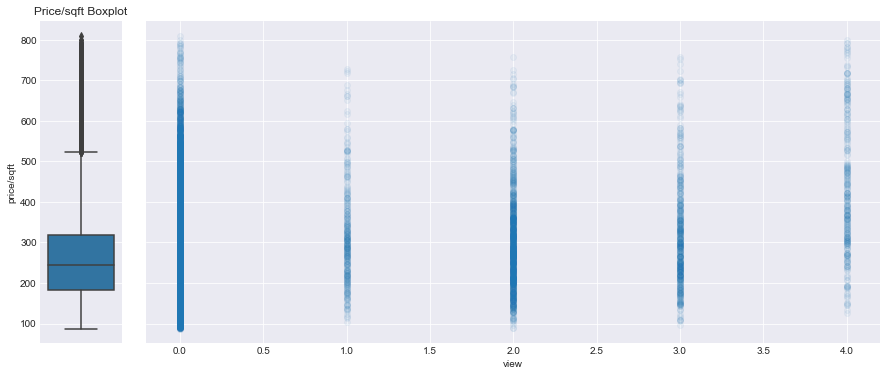

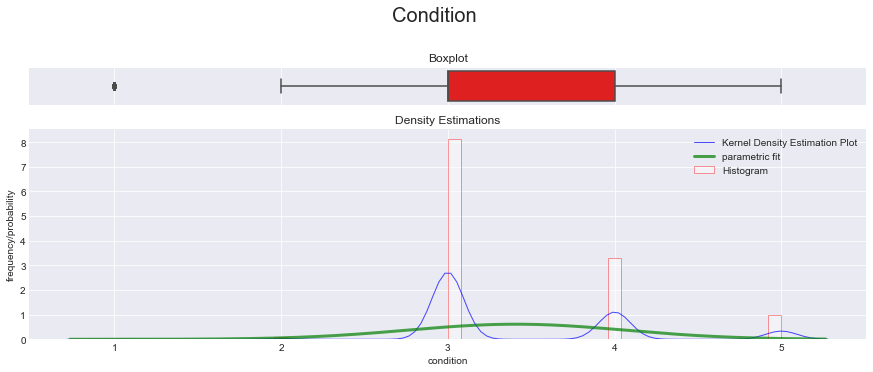

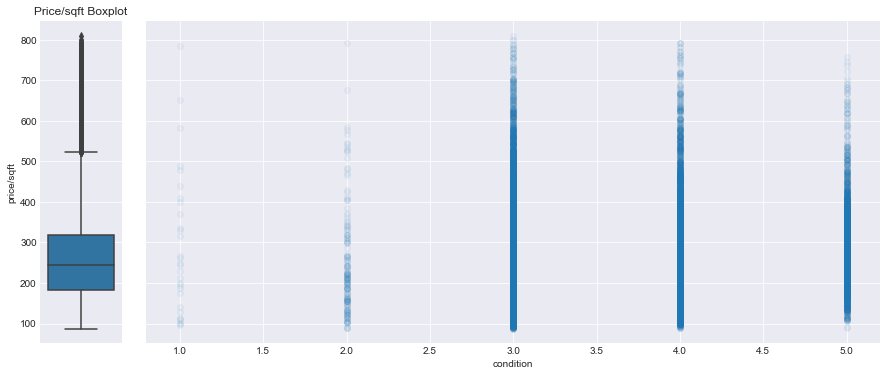

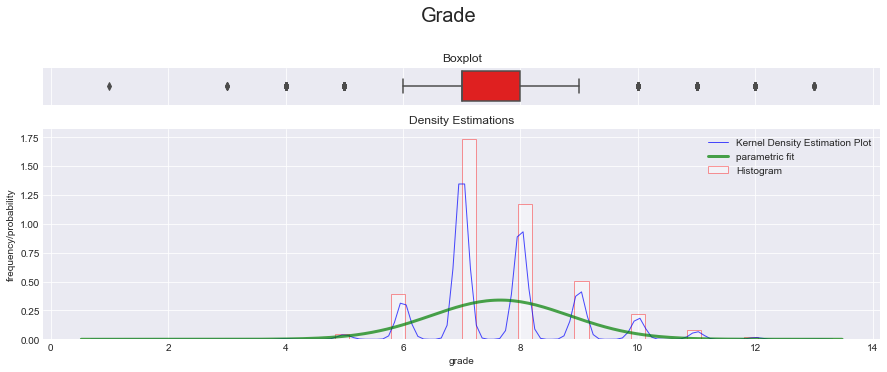

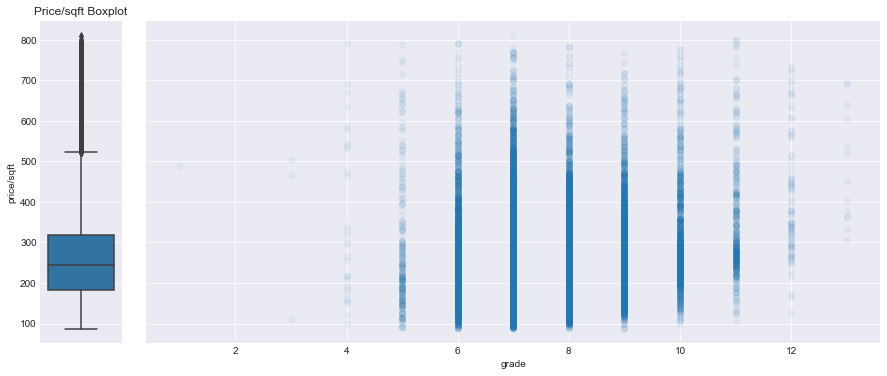

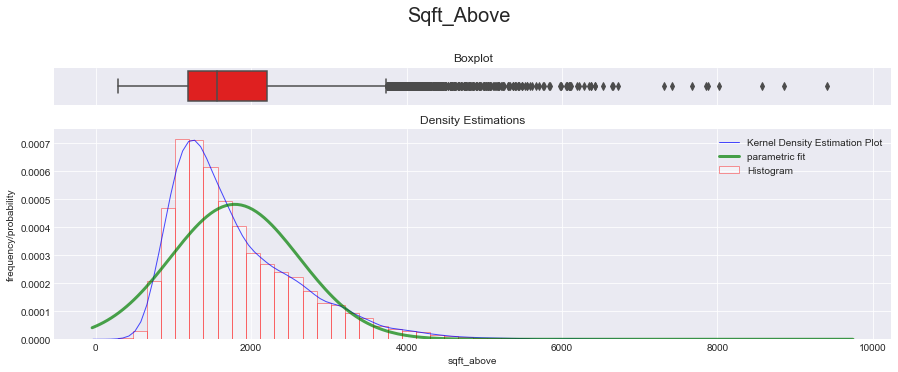

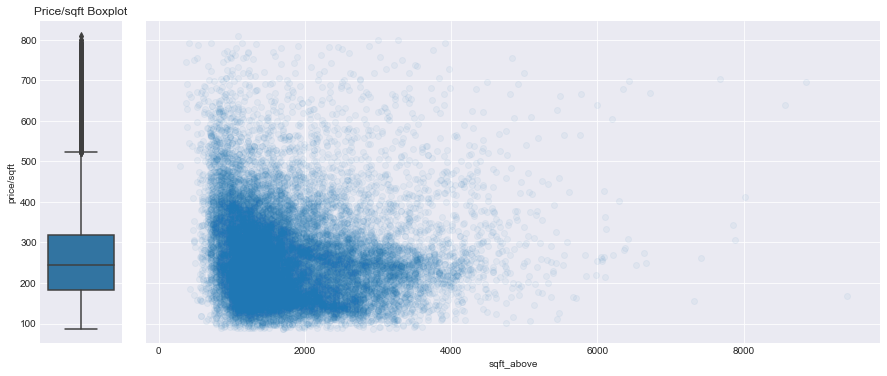

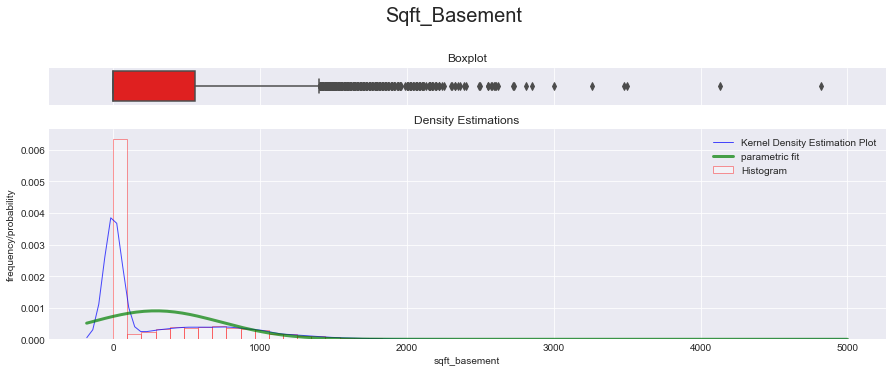

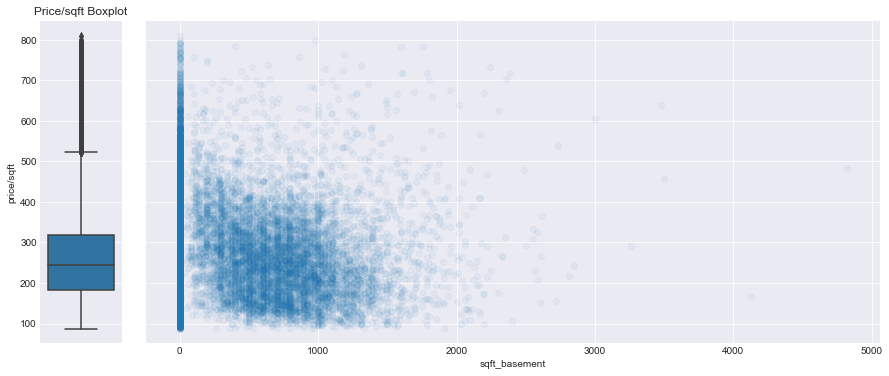

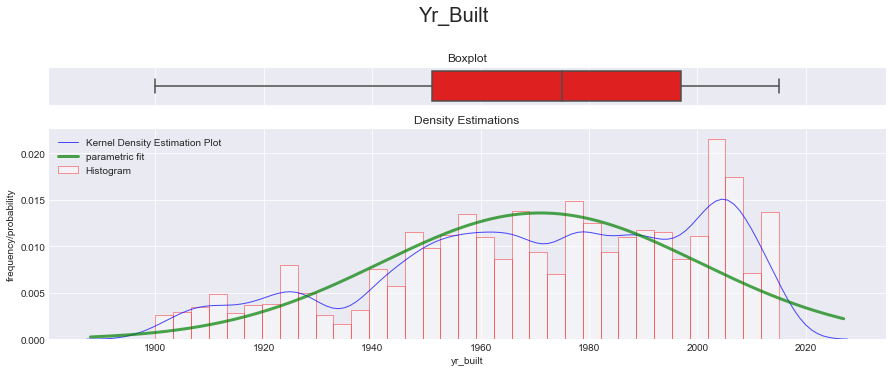

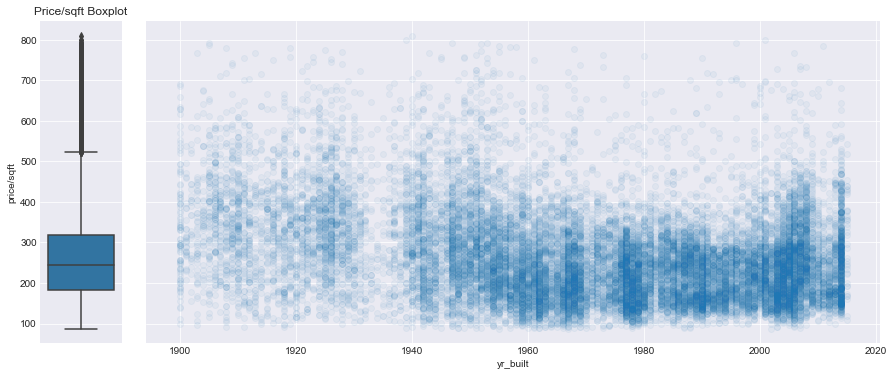

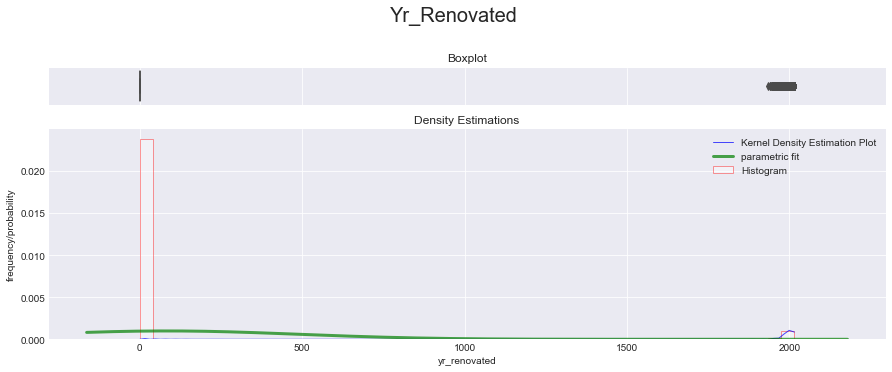

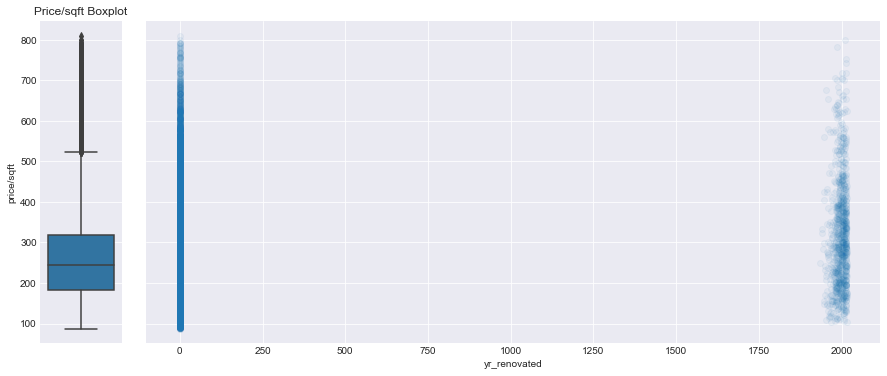

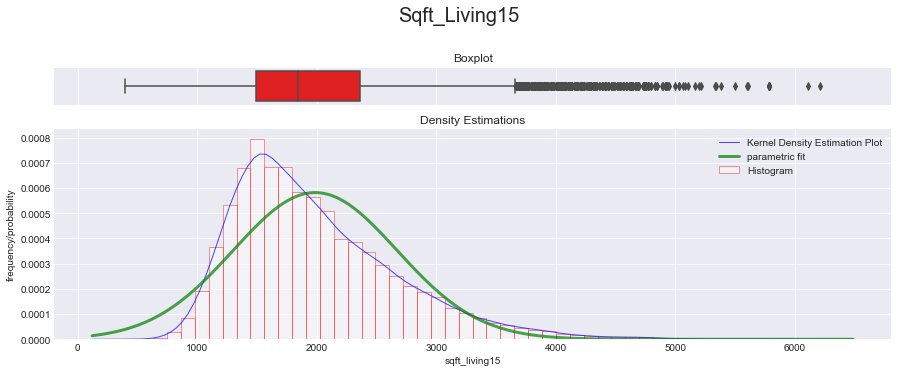

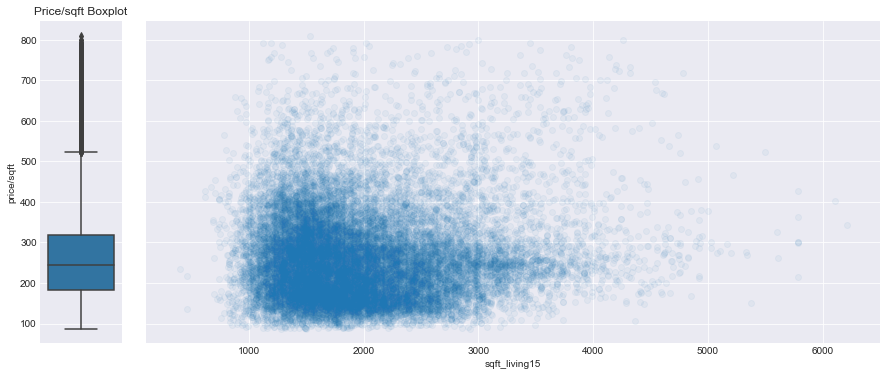

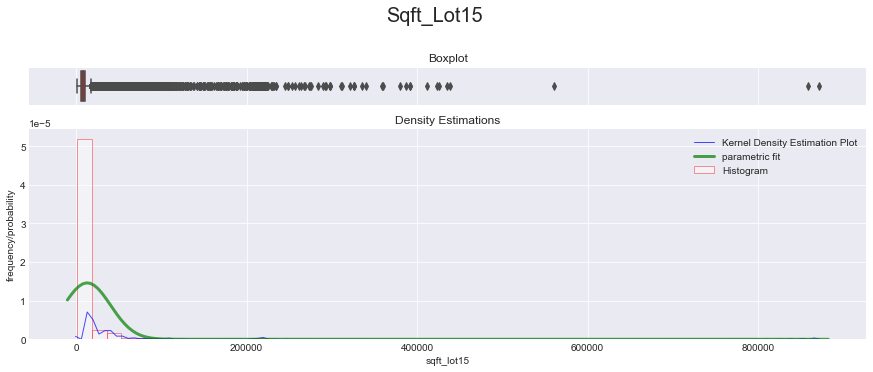

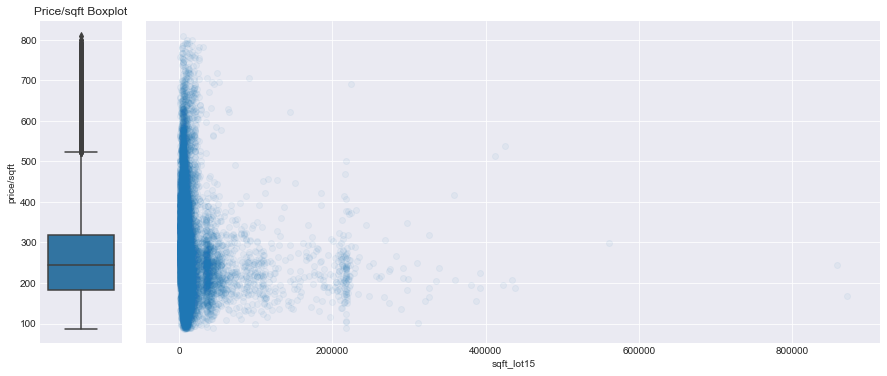

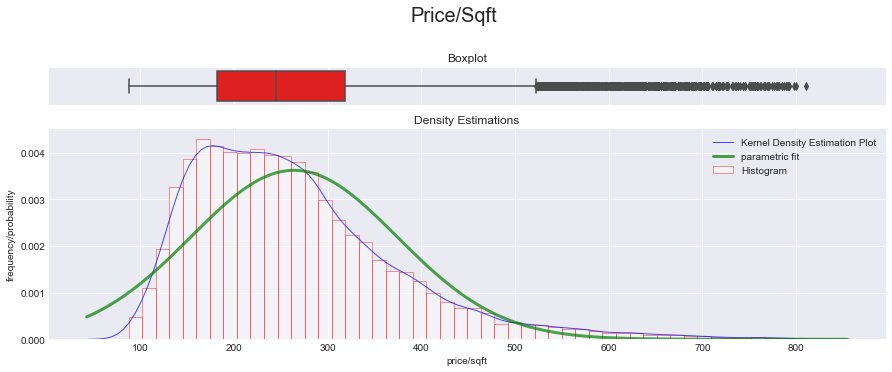

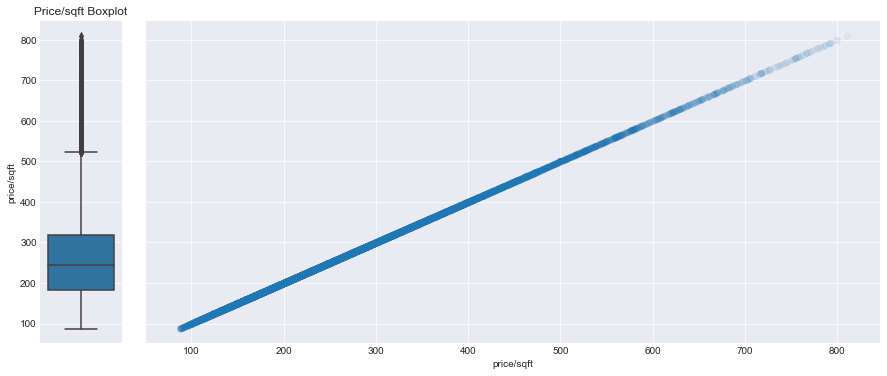

In [22]:
import scipy.stats as stats

not_to_plot = ['coord', 'id', 'price', 'date', 'zipcode','lat', 'long', 'price' ]
to_plot = [col for col in df.keys() if col not in not_to_plot]

for col in to_plot:
    
    fig, axes = plt.subplots(2, sharex='col', 
                                  gridspec_kw={"height_ratios": (.15, .85)}, figsize = (15,5) )
    fig.suptitle(col.title(), fontsize=20).set_position([.5, 1.05])
    
    
    
    # top  plot
    sns.boxplot(x=df[col], ax = axes[0],color = 'red')
    axes[0].set_title('Boxplot', fontsize=12)
    axes[0].set_xlabel('')

    
    # middle plot
    sns.distplot(df[col], 
                 hist=True, 
                 hist_kws={"linewidth": 1,"edgecolor" :'red', "alpha": 0.4,
                           "color":  "w", "label": "Histogram"},
                 kde=True, kde_kws = {'linewidth': 1, 'color': "blue", 
                                      "alpha": 0.7,
                                      'label':'Kernel Density Estimation Plot'},
                 fit= stats.norm, fit_kws = {'color' : 'green',
                                         'label' : 'parametric fit',
                                         "alpha": 0.7,
                                          'linewidth':3},
                 ax=axes[1])
    
    
    axes[1].set_title('Density Estimations', fontsize=12)
    axes[1].set_ylabel('frequency/probability')
    axes[1].set_xlabel(col)
    axes[1].legend()
    
    plt.show()
    
    
    ################
    fig2, axes2 = plt.subplots(1, 2, sharey='row', 
                             gridspec_kw={"width_ratios": (.1, .9)}, figsize = (12.3,5) )
    fig2.tight_layout()
    # bottom left plot
    sns.boxplot(y="price/sqft", data=df, ax=axes2[0])
    #axes2[0].set_xticks([])
    axes2[0].set_xlabel('')
    axes2[0].set_title('Price/sqft Boxplot', fontsize=12)

    
    
    
    # bottom right plot
    axes2[1].scatter(df[col], df["price/sqft"],alpha=.051)
    axes2[1].set_xlabel(col)
    axes2[1].set_ylabel('')

    #plt.legend();
    plt.show()

In [23]:


def create_colinearity_df(correlation_hurdle, variables_list, df):
    """Function that finds which variables have correlation above a 
    certain threshold.
    
    ***
    Function takes in as arguments a correlation hurdle, a list of variables 
    and a Data Frame.
    
    Returns a correlation matrix as a pandas Data Frame
    ***
    Arguments:
    - correlation_hurdle : float between 0 and 1
    - variables_list: list of strings with variable names. Must be a column 
    name of the provided data frame
    - df : a DataFrame containing the data for the variables.
    
    """
    
    # creates a new df from a correlation matrix
    # multi index structure 
    correlations_df = pd.DataFrame(
        df[variables_list].corr().stack()).reset_index()
    
    # removes redundant correlations
    index_drop = correlations_df[
        correlations_df['level_0'] == correlations_df['level_1']].index
    correlations_df.drop(index=index_drop, inplace=True)

    # renames columns, resets index
    correlations_df.columns= ['x', 'y', 'corr']
    correlations_df.reset_index(inplace=True)
    correlations_df.drop(columns='index', inplace=True)
    
    # creates new column with the correlated pairs
    correlations_df['pair'] = list(zip(correlations_df['x'], correlations_df['y']))
    
    # drops columns used to create the pairs' column
    correlations_df.drop(columns=['x', 'y'], inplace=True)
    
    # sets the pairs as new index
    correlations_df.set_index('pair', inplace=True)
    
    # drops duplicates
    correlations_df.drop_duplicates(inplace=True)

    
    # returns only pairs with correlation above hurdle
    return correlations_df[abs(correlations_df['corr']) > correlation_hurdle]

create_colinearity_df(0.70, to_plot, df)

,corr
pair,
"(bathrooms, sqft_living)",0.754665
"(sqft_living, grade)",0.762704
"(sqft_living, sqft_above)",0.876597
"(sqft_living, sqft_living15)",0.756420
"(sqft_lot, sqft_lot15)",0.718557
"(grade, sqft_above)",0.755923
"(grade, sqft_living15)",0.713202
"(sqft_above, sqft_living15)",0.731870


C:\Users\felip\anaconda3\envs\learn-env\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\felip\anaconda3\envs\learn-env\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\felip\anaconda3\envs\learn-env\lib\site-packages\pandas\plotting\_tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\felip\anaconda3\envs\learn-env\lib\site-pack

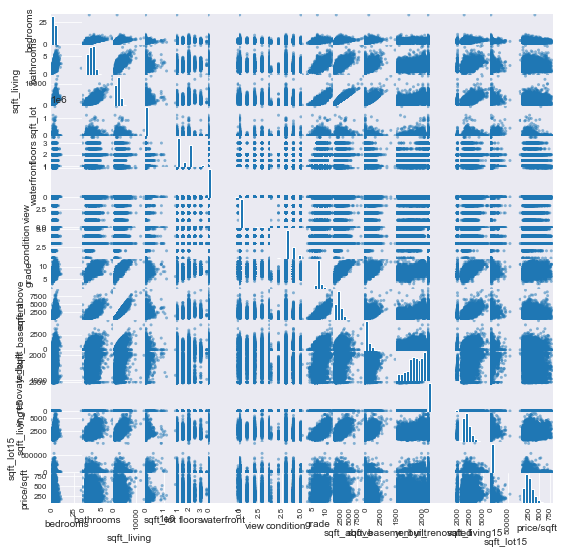

In [24]:
pd.plotting.scatter_matrix(df[to_plot],figsize =[9, 9]);